# ML: Breast Cancer

## Part 0: Pre-requisites 

### Imports

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import cv

### Function to plot the learning curve 

In [2]:
def plot_learning_curves(model, x_train, y_train, x_val, y_val):
    train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

### Function to split the data 

In [3]:
def train_val_test_split(x, y):
    # Splitting into training (80%) and temporary set (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=3)
    # Splitting the temporary set into validation (50%) and test (50%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, shuffle=True, random_state=3)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [4]:
# Used locally 
path = "D:\\Desktop\\ML\\Project\\ML_Breast_Cancer\\Sumaya\\Models\\"

# Used to load and save models for later use

def saveModel(fileName, model):
  with open(path + fileName, 'wb') as f:
      pickle.dump(model, f)

def getModel(fileName):
  with open(path + fileName, 'rb') as f:
      loaded_model = pickle.load(f)
  return loaded_model

In [5]:
results = [] # Array used to store tuples of (model, accuracy_score)

## Part 1: Data 


### Load the data 

In [6]:
data = pd.read_csv("data.csv", encoding="utf-8")
data.head()

C:\Users\Sumaya\AppData\Local\Temp\ipykernel_30512\3240169054.py:1: DtypeWarning: Columns (662,664,676,677,683,685,686,687) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data.csv", encoding="utf-8")


,cancer_type,patient_id,age_at_diagnosis,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,Breast Invasive Ductal Carcinoma,474,54.29,High,1,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Breast Invasive Ductal Carcinoma,7029,43.45,Moderate,0,LumA,4,Positve,Positive,1.0,...,0,0,0,0,0,0,0,0,0,0
2,Breast Invasive Ductal Carcinoma,5215,74.11,High,0,LumB,3,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0
3,Breast Invasive Ductal Carcinoma,5412,51.87,High,0,LumA,3,Positve,Positive,2.0,...,0,0,0,0,0,0,0,0,0,0
4,Breast Invasive Ductal Carcinoma,465,87.18,Moderate,0,LumB,1,Positve,Positive,3.0,...,0,0,0,0,0,0,0,0,0,0


### Clean the data

#### Remove missing and duplicate values from dataset

In [7]:
# Check and remove missing values from the dataset
data.isna().sum()
data.dropna(axis=0, inplace=True)
data.reset_index(inplace=True)

In [8]:
# Check and remove duplicate values from the dataset
data.duplicated().sum()
data.drop_duplicates(inplace=True)

#### Split the data into train, validation, and test sets 

Given the dataset size (around 1500) we can go with either approach (spliting the data manualy or applying cross-validation)

Split the dataset into train (80%), validation (10%) and test (10%) sets

In [9]:
y = data["cancer_type"]
x = data.drop(columns=['cancer_type', 'patient_id'])

# Encode the target variable
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

# Identify and convert all categorical features in x to string type
categorical_features = x.select_dtypes(include=['object', 'int64']).columns
for col in categorical_features:
    x[col] = x[col].astype(str)  # Convert all entries to strings
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col])

# Split the data
x_train, x_temp, y_train, y_temp = train_test_split(x, y_encoded, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


## Part 2: Dimensionality Reduction

In [10]:
# Standard scaling before PCA
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Adjust components based on explained variance you wish to retain
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

## Part 3: Feature Selection


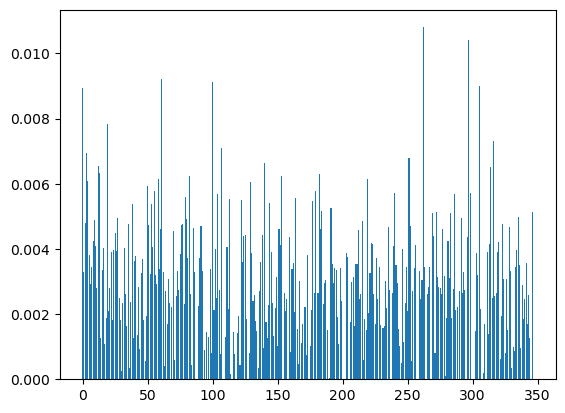

In [11]:
# Initial model to evaluate feature importance
initial_model = XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic'
)
initial_model.fit(x_train_pca, y_train)

# Get feature importance and visualize it
importances = initial_model.feature_importances_
plt.bar(range(len(importances)), importances)
plt.show()

# Select features based on importance threshold
threshold = 0.01  # Set a threshold for feature importance
selected_features = [i for i, importance in enumerate(importances) if importance > threshold]
x_train_selected = x_train_pca[:, selected_features]
x_val_selected = x_val_pca[:, selected_features]
x_test_selected = x_test_pca[:, selected_features]

## Part 4: Model training

### XGBoost

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Specify the parameter distributions
param_distributions = {
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

# Perform the random search
random_search.fit(x_train_selected, y_train)

# Best hyperparameters and scores
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)
best_score = random_search.best_score_
print("Best Cross-Validation Score:", best_score)

# Train the best model from random search
best_model = random_search.best_estimator_
y_val_pred = best_model.predict(x_val_selected)
val_score = accuracy_score(y_val, y_val_pred)
print("Validation Set Accuracy:", val_score)

saveModel('xgb2.pkl', best_model)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Hyperparameters: {'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 2}
Best Cross-Validation Score: 0.7811158798283261
Validation Set Accuracy: 0.8275862068965517
